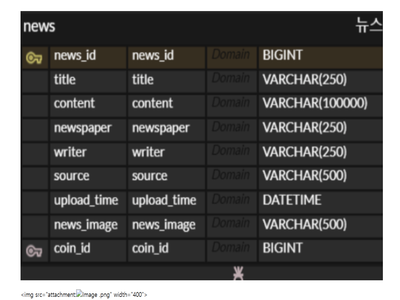

In [5]:
from PIL import Image
from IPython.display import display
import os

# 파일 경로 수정 (현재 주피터 노트북 기준)
file_path = "./Data/news_table_erd.png"

# 파일이 존재하는지 확인
if os.path.exists(file_path):
    # print("✅ 파일이 존재합니다! 이미지 로드 시작.")
    
    img = Image.open(file_path)
    
    # 크기 조정 + 품질 유지
    resized_img = img.resize((400, 300), Image.Resampling.LANCZOS)

    # 이미지 출력
    display(resized_img)
else:
    print("❌ 파일을 찾을 수 없습니다. 경로를 확인하세요.")


In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
from datetime import datetime
from IPython.display import display, HTML

# CryptoPanic API 설정
API_KEY = "836cfd356356c24c55981ab263ba84a9f3c4941c"
API_URL = f"https://cryptopanic.com/api/v1/posts/?auth_token={API_KEY}"

# Selenium 실행 옵션
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("user-agent=Mozilla/5.0")

# ChromeDriver 자동 설치 및 실행
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# 날짜 파싱 함수 (GMT+0900 제거)
def parse_datetime(time_element):
    try:
        raw_datetime = time_element["datetime"] if time_element else "N/A"
        cleaned_datetime = re.sub(r" GMT[+-]\d{4} \(.*?\)", "", raw_datetime)
        return datetime.strptime(cleaned_datetime, "%a %b %d %Y %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print(f"⚠️ 시간 파싱 오류: {str(e)}")
        return "N/A"

# **원본 뉴스 링크 가져오기 함수**
def get_original_news_link(soup):
    try:
        detail_pane = soup.find("div", id="detail_pane")
        if detail_pane:
            links = detail_pane.find_all("a", href=True)
            for link in links:
                if "http" in link["href"]:  
                    return link["href"]
        return "N/A"
    except Exception as e:
        print(f"⚠️ 원본 뉴스 링크 가져오기 오류: {str(e)}")
        return "N/A"

# **뉴스 개수 설정**
NEWS_COUNT = 5

# **결과 저장을 위한 리스트**
news_data = []

### **1️⃣ CryptoPanic API에서 뉴스 목록 가져오기**
try:
    response = requests.get(API_URL, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    for index, post in enumerate(data["results"][:NEWS_COUNT], start=1):  # ✅ news_id 자동 추가 (1부터 시작)
        title_en = post["title"]
        title_ko = GoogleTranslator(source="en", target="ko").translate(title_en)
        crypto_panic_url = post["url"]
        coin_ticker = post.get("currencies", [{}])[0].get("code", "N/A")
        newspaper = post["source"]["title"] if "source" in post else "N/A"  # ✅ newspaper 컬럼 추가

        # Selenium으로 뉴스 페이지 접속
        driver.get(crypto_panic_url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # 원본 뉴스 링크 가져오기
        original_news_link = get_original_news_link(soup)

        # 뉴스 날짜 가져오기
        time_element = soup.find("time")
        news_datetime = parse_datetime(time_element)

        # 뉴스 요약 가져오기
        description_div = soup.find("div", class_="description")
        if description_div:
            article_text = "\n".join([p.get_text() for p in description_div.find_all("p")])
            translated_text = GoogleTranslator(source="en", target="ko").translate(article_text)
        else:
            translated_text = "❌ 뉴스 요약 없음"

        # ✅ 데이터 저장 (news_id, newspaper 포함)
        news_data.append([index, title_ko, translated_text, newspaper, original_news_link, news_datetime, coin_ticker])

except Exception as e:
    print(f"❌ CryptoPanic API 요청 오류: {str(e)}")

finally:
    driver.quit()

# **결과를 데이터프레임으로 변환**
df = pd.DataFrame(news_data, columns=["news_id", "title", "content", "newspaper", "source", "upload_time", "coin_id"])

# **컬럼 순서 조정**
df = df[["news_id", "title", "content", "newspaper", "source", "upload_time", "coin_id"]]

# ✅ **원본 뉴스 링크를 하이퍼링크로 변환**
df["source"] = df["source"].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>' if x != "N/A" else "N/A")

# ✅ **인덱스 제거하고 데이터프레임만 출력**
df_html = df.to_html(escape=False, index=False)  # 🔥 index=False 옵션 추가!

# **출력**
display(HTML(df_html))


news_id,title,content,newspaper,source,upload_time,coin_id
1,Abra Global CEO는 Crypto의 '주기적 Valhalla'를 예상합니다. 왜?,대규모 유동성 주입-비트 코인이 마침내 사상 최고를 산산조각 낼 것인가?,AMBCrypto,https://ambcrypto.com/abra-global-ceo-foresees-a-cyclical-valhalla-for-crypto-why/,2025-02-10 18:00:33,BTC
2,비트 코인 자금 조달 률은 긍정적이지만 시장 이동의 위험,"Cryptocurrency Analytics 회사 인 Alphractal은 Bitcoin에 대한 새로운 분석을 발표했으며, 최근 가격 하락에도 불구하고 주요 거래소의 전체 자금 조달 속도는 여전히 긍정적 인 것으로 남아 있습니다.\n비트 코인 자금 조달 률은 여전히 ​​긍정적이지만, 시장 교대의 위험은 Cryptodnes에서 처음으로 나타났습니다.",cryptodnes,https://cryptodnes.bg/en/bitcoin-funding-rates-remain-positive-but-risks-of-market-shift-loom/,2025-02-10 18:00:27,BTC
3,사우디 아라비아는 $ 14.9B AI 확장으로 기술 거인과 파트너 관계,"사우디 아라비아는 Google, Lenovo 및 Alibaba를 포함한 글로벌 기술 파트너십을 통해 지역 AI 허브가되는 것을 목표로 AI에 149 억 달러를 투입했습니다.",CoinTelegraph,https://cointelegraph.com/news/saudi-arabia-to-invest-14-9-b-in-ai-cloud?utm_source=rss_feed&utm_medium=rss&utm_campaign=rss_partner_inbound,2025-02-10 17:50:21,N/A
4,월스트리트의 이더 리움 짧은 베팅은 폭발 - 투자자들은 걱정해야합니까?,"극적인 교대로, 헤지 펀드는 이전에 보지 못한 속도로 이더 리움에서 짧은 포지션을 늘리고있는 것으로 보이며, 시가 총액에 의한 두 번째로 큰 암호 화폐가 문제가있는 물에 직면 할 수 있는지 또는 다른 일이 발생하는 경우에 대한 의문을 제기합니다. Kobeissi Letter (@kobeissiletter)의 유명한 분석가들에 따르면 Ethereum의 짧은 포지셔닝은 이제 +40% 증가했습니다 ...",NewsBTC,https://www.newsbtc.com/news/wall-street-ethereum-shorts-explode/,2025-02-10 17:50:21,BTC
5,전직 Binance Chief CZ는 암호 자산에 대한 황금 규칙을 추종자들에게 상기시킵니다.,세계 최대의 교환의 전 보스 인 Binance는 암호화 부에 대한 황금률을 추종자들에게 상기시킵니다.,U.Today,https://u.today/ex-binance-chief-cz-reminds-followers-of-his-golden-rule-for-crypto-wealth,2025-02-10 17:50:21,N/A
